# Introduction
We have received finance data about stocks opening, closing prices and other 15 features on which prices are dependent. We'll try to fit various models to this data to check whether returns are positive or not. We have tried 2 versions of Dense Net and 2 versions of LSTMs for predicting whether returns are positive or not.

In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import copy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, mean_squared_error, r2_score, multilabel_confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, f_regression
from sklearn.preprocessing import LabelEncoder

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils import np_utils
from keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 3)
np.set_printoptions(precision=3)

%matplotlib inline

Using TensorFlow backend.


# Loading & Cleaning Data
Loading data involved loading data from CSV file wheareas cleaning data refers to handling of NAs. We also have introduced new columns like returns which is percentage change in closing price and label which is 1 if return is positive else 0.

In [2]:
data=pd.read_csv('/kaggle/input/input_data.csv')
data['Time'] = pd.to_datetime(data['Time'].values, format='%m/%d/%Y')
data = data.set_index('Time')
## Calculate % Change of Closing Price
#data['ret_final']=(data['Close'].shift(-1)-data['Close'])/data['Close']
data['ret_final'] = data.Close.pct_change()
data['ret_final'] = data.fillna(0)
#data['label'] = [(1 if j>0 else 0) for j in data.ret_final]

def calculate_down_label(index, percent = 0.0, count=0):
    down_value = percent * data['Close'][index]
    count_sum = 0
    for i in range(0, count):
        count_index = index + i + 1
        if data.shape[0] <= count_index:
            break
        if data['Close'][count_index] <= down_value:
            count_sum += 1
    return 1 if count_sum > 0 else 0 # I feel that this should be = rather than >.

def calculate_up_label(index, percent=0.0, count=0):
    down_value = percent * data['Close'][index]
    count_sum = 0
    for i in range(0, count):
        count_index = index + i + 1
        if data.shape[0] <= count_index:
            break
        if data['Close'][count_index] >= down_value:
            count_sum += 1
    return 1 if count_sum > 0 else 0 # I feel that this should be = rather than >. 

data['label_down_5'] = [calculate_down_label(i, 0.95, 5) for i in range(data.shape[0])]
data['label_down_4'] = [calculate_down_label(i, 0.96, 4) for i in range(data.shape[0])]
data['label_down_3'] = [calculate_down_label(i, 0.97, 3) for i in range(data.shape[0])]
data['label_down_2'] = [calculate_down_label(i, 0.98, 2) for i in range(data.shape[0])]
data['label_down_1'] = [calculate_down_label(i, 0.99, 1) for i in range(data.shape[0])]
data['label_up_1'] = [calculate_up_label(i, 1.01, 1) for i in range(data.shape[0])]
data['label_up_2'] = [calculate_up_label(i, 1.02, 2) for i in range(data.shape[0])]
data['label_up_3'] = [calculate_up_label(i, 1.03, 3) for i in range(data.shape[0])]
data['label_up_4'] = [calculate_up_label(i, 1.04, 4) for i in range(data.shape[0])]
data['label_up_5'] = [calculate_up_label(i, 1.05, 5) for i in range(data.shape[0])]

data = data.fillna(0)
data.head()

,Open,High,Low,Close,Volume,feature1,feature2,feature3,feature4,feature5,...,label_down_5,label_down_4,label_down_3,label_down_2,label_down_1,label_up_1,label_up_2,label_up_3,label_up_4,label_up_5
Time,,,,,,,,,,,,,,,,,,,,,
2008-10-15,14.83,15.29,13.98,13.99,387619900,0.0,-0.641,0.0,0.0,0.0,...,1,1,0,0,0,1,1,1,1,0
2008-10-16,14.25,14.86,13.11,14.56,480128000,0.0,0.177,0.0,0.0,0.0,...,1,1,1,1,1,0,0,0,0,0
2008-10-17,14.21,14.58,13.86,13.91,433964800,0.0,-0.417,0.0,0.0,0.0,...,1,1,1,1,0,1,0,0,0,0
2008-10-20,14.26,14.29,13.38,14.06,383539500,0.0,-0.220,0.0,0.0,0.0,...,1,1,1,1,1,0,0,0,0,0
2008-10-21,13.86,13.99,13.00,13.07,446705000,0.0,-0.798,0.0,0.0,0.0,...,0,0,0,0,0,1,1,1,1,1


In [3]:
target_col_order = ['label_down_5','label_down_4', 'label_down_3','label_down_2','label_down_1','label_up_1','label_up_2','label_up_3', 'label_up_4','label_up_5']
print('Entries with more than 1 labels : ', sum([1 for val in data[target_col_order].values if sum(val) > 1]))

Entries with more than 1 labels :  1197


## Dividing Data Into Train/Test Sets

In [4]:
X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']]
Y_one_hot = data[target_col_order].values

ret_vals = data['ret_final'].values

X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.8, test_size=0.2, shuffle=False)

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Train/Test Sizes : ', X_train.shape, X_test.shape, Y_train_one_hot.shape, Y_test_one_hot.shape)
print('Actual Return Sizes : ', actual_rets_test.shape)

Train/Test Sizes :  (2204, 15) (552, 15) (2204, 10) (552, 10)
Actual Return Sizes :  (552,)


### Finance Metrics
Below are some of finance evaluation metrics

In [5]:
def WR(returns,predictions):
    total_trades = predictions.sum()
    wins= ((returns*predictions)>0).sum()
    return(wins/total_trades)

def ARR(returns,predictions):
    total_trades = predictions.sum()
    all_returns = returns*predictions
    total_return = all_returns.sum()
    gain=(total_return)/total_trades
    arr=((1+gain))**252-1
    useful_returns=[all_returns[j] for j in range(len(predictions)) if predictions[j]==1]
    sigma=np.std(np.array(useful_returns))
    asr=np.sqrt(252)*gain/sigma
    return([arr,asr])

def MDD(returns,predictions):
    all_returns= returns*predictions
    cum_vals=np.cumprod(all_returns+1)
    i = np.argmax(np.maximum.accumulate(cum_vals) - cum_vals) # end of the period
    j = np.argmax(cum_vals[:i]) # start of period
    mdd=(cum_vals[j]- cum_vals[i])/cum_vals[j]
    return(mdd)

### Visualisation Generic Functions
Below we have designed 2 function which will help up print various results.

1. `plot_confusion_matrix` - Plots confusion matrix given actual values and predictions
2. `plot_loss_and_accuracy` - Plots train/val loss and train/val accuracy for classification task and train/val MSE for regression task.

In [6]:
def plot_confusion_matrix(actuals, preds):
    conf_mat = confusion_matrix(Y_test, predictions)
    with plt.style.context(('seaborn', 'ggplot')):
        fig = plt.figure(figsize=(10,10))
        plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
        plt.grid(None)
        plt.xticks(range(len(target_cols)), target_cols)
        plt.yticks(range(len(target_cols)), target_cols)
        plt.ylabel('Actual')
        plt.xlabel('Prediction')
        plt.colorbar();
        for i in range(conf_mat.shape[0]):
            for j in range(conf_mat.shape[1]):
                plt.text(j, i, str(conf_mat[i, j]), horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
                
def plot_loss_and_accuracy(hist, prob_type='classification'):
    with plt.style.context(('seaborn', 'ggplot')):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(hist.history['loss'], label='Train Loss')
        plt.plot(hist.history['val_loss'], label='Val Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        
        if prob_type=='classification':
            plt.subplot(122)
            plt.plot(hist.history['accuracy'], label='Train Accuracy')
            plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc='best')
        elif prob_type=='regression':
            plt.subplot(122)
            plt.plot(hist.history['mse'], label='Train MSE')
            plt.plot(hist.history['val_mse'], label='Val MSE')
            plt.xlabel('Epochs')
            plt.ylabel('MSE')
            plt.legend(loc='best')

# DenseNet v1
Below dense model consist of 4 dense layers with dimensions 128, 64,32,1 respectively. For internal layers we have selected activation function as relu. Last layer has activation function as sigmoid because its classification problem.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
Total params: 12,714
Trainable params: 12,714
Non-trainable params: 0
_________________________________________________________________
None


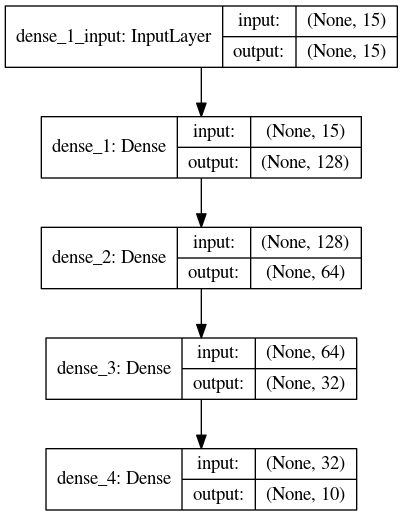

In [7]:
dense_model1 = Sequential([ Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
                     Dense(64,  activation='relu'),
                     Dense(32,  activation='relu'),
                     Dense(Y_train_one_hot.shape[1],   activation='sigmoid')])

print(dense_model1.summary())
plot_model(dense_model1, to_file='dense1.png', show_shapes=True)
Image.open('dense1.png')

## Compiling Model
Compiling Model involves setting optimizers to use, loss and evaluation metrics.

In [8]:
dense_model1.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model
Below we are fitting model with batch size of 4 for 25 epochs. We'll use 10% of train data as validation data for evaluation of performance during training.

In [9]:
history = dense_model1.fit(X_train, Y_train_one_hot, batch_size=8, epochs=25, validation_split=0.1, shuffle=False, use_multiprocessing=True);

Train on 1983 samples, validate on 221 samples
Epoch 1/25
1983/1983 [==============================] - 1s 411us/step - loss: 0.5469 - accuracy: 0.7876 - val_loss: 0.2613 - val_accuracy: 0.9344
Epoch 2/25
1983/1983 [==============================] - 0s 236us/step - loss: 0.5045 - accuracy: 0.7972 - val_loss: 0.2512 - val_accuracy: 0.9348
Epoch 3/25
1983/1983 [==============================] - 0s 237us/step - loss: 0.4906 - accuracy: 0.8077 - val_loss: 0.2540 - val_accuracy: 0.9348
Epoch 4/25
1983/1983 [==============================] - 0s 237us/step - loss: 0.4870 - accuracy: 0.8071 - val_loss: 0.2506 - val_accuracy: 0.9348
Epoch 5/25
1983/1983 [==============================] - 0s 237us/step - loss: 0.4800 - accuracy: 0.8106 - val_loss: 0.2560 - val_accuracy: 0.9348
Epoch 6/25
1983/1983 [==============================] - 0s 238us/step - loss: 0.4773 - accuracy: 0.8108 - val_loss: 0.2542 - val_accuracy: 0.9348
Epoch 7/25
1983/1983 [==============================] - 0s 238us/step - loss:

## Visualizing Training Stage Results

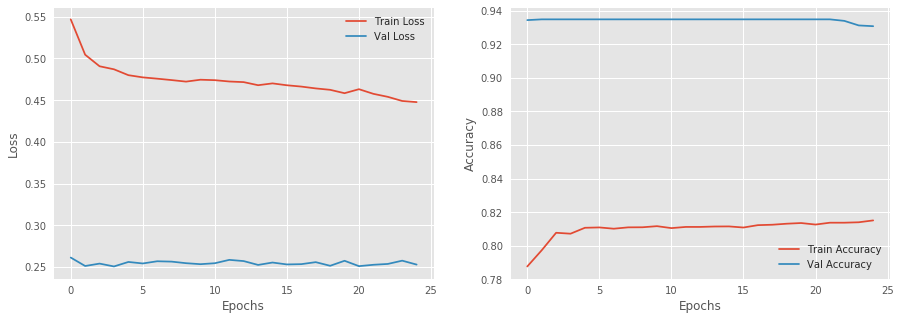

In [10]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [11]:
loss, acc = dense_model1.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

552/552 [==============================] - 0s 28us/step
Accuracy : 0.847


In [12]:
loss, acc = dense_model1.evaluate(X,Y_one_hot)
print('Accuracy : %.3f'%acc)

2756/2756 [==============================] - 0s 27us/step
Accuracy : 0.831


In [13]:
probs = dense_model1.predict_proba(X)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_col_order[i])
    pred_labels.append(l)
    
df1 = copy.deepcopy(data)
df1['Preds'] = pred_labels
for i, col in enumerate(target_col_order):
    df1[col + '_probs'] = probs[:,i]

## Printing/Plotting Classification Metrics

In [14]:
results = []
def print_plot_metrics(model_name, actual_rets_test, Y_test, predictions):
    #wr_mlp, vals, mdd_mlp = WR(actual_rets_test,predictions), ARR(actual_rets_test,predictions), MDD(actual_rets_test,predictions)
    #arr_mlp, asr_mlp=vals[0], vals[1]
    #results.append([model_name, wr_mlp, arr_mlp, asr_mlp, mdd_mlp])

    #print('Classification Report : \n',classification_report(Y_test, predictions))
    print('Confusion Matrix : \n', multilabel_confusion_matrix(Y_test_one_hot, predictions))

predictions = dense_model1.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('DenseNetv1', actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[387 104]
  [ 27  34]]

 [[365 122]
  [ 25  40]]

 [[270 212]
  [ 15  55]]

 [[242 215]
  [ 19  76]]

 [[289 160]
  [ 24  79]]

 [[  6 412]
  [  0 134]]

 [[ 96 342]
  [ 22  92]]

 [[212 252]
  [ 32  56]]

 [[393  91]
  [ 44  24]]

 [[436  64]
  [ 43   9]]]


## Visualising Weights
Below we are visualising average weights of first layer which has same shape as that of number of features.

Layer : Dense : Weights : (15, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 10)
Layer : Dense : Bias : (10,)


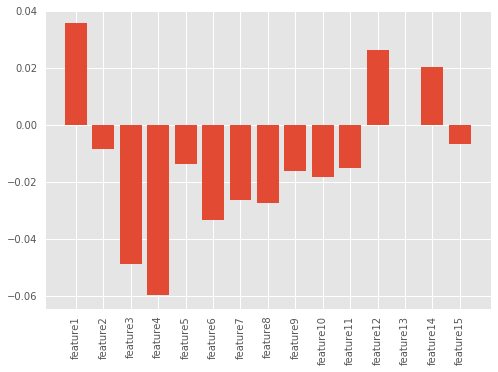

In [15]:
def print_weights_per_layer(model):
    weights = model.get_weights()
    layers = [layer for layer in model.layers if layer.__class__.__name__ != 'Dropout']

    i = 0
    for layer in layers:
        if layer.__class__.__name__ =='Dense':
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            print('Layer : %s : Bias : %s'%(layer.__class__.__name__, weights[i+1].shape))
            i = i+2
        else:
            print('Layer : %s : Weights : %s'%(layer.__class__.__name__, weights[i].shape))
            i = i+1

print_weights_per_layer(dense_model1)

dense_weights = dense_model1.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# DenseNet v2
Below we have deisigned another dense net model which has 6 layers of shapes 512,256,128,64,32 and 1 respectively. We have used relu as activation function for internal layers and sigmoid for last layer. We also have used Dropout of 20% this time between each layer to see whether it help improve performance.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)               

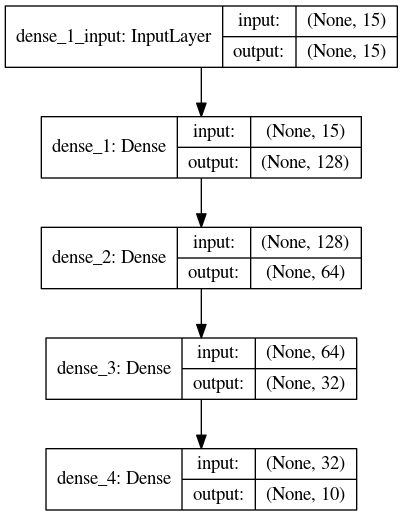

In [16]:
dense_model2 = Sequential([ 
                     Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
                     Dropout(0.2),
                     Dense(256,  activation='relu'),
                     Dropout(0.2),
                     Dense(128,  activation='relu'),
                     Dropout(0.2),
                     Dense(64,  activation='relu'),
                     Dropout(0.2),
                     Dense(32,  activation='relu'),
                     Dropout(0.2),
                     Dense(Y_train_one_hot.shape[1],   activation='sigmoid')])

print(dense_model2.summary())
plot_model(dense_model1, to_file='dense2.png', show_shapes=True)
Image.open('dense2.png')

## Compiling Model

In [17]:
dense_model2.compile('adam', loss='binary_crossentropy', metrics = ['accuracy'])

## Fitting Model

In [18]:
history = dense_model2.fit(X_train, Y_train_one_hot, batch_size=8, epochs=25, validation_split=0.1, shuffle=False, use_multiprocessing=True);

Train on 1983 samples, validate on 221 samples
Epoch 1/25
1983/1983 [==============================] - 2s 805us/step - loss: 0.5888 - accuracy: 0.7284 - val_loss: 0.2393 - val_accuracy: 0.9348
Epoch 2/25
1983/1983 [==============================] - 1s 588us/step - loss: 0.5194 - accuracy: 0.7972 - val_loss: 0.2431 - val_accuracy: 0.9348
Epoch 3/25
1983/1983 [==============================] - 1s 567us/step - loss: 0.5126 - accuracy: 0.8052 - val_loss: 0.2559 - val_accuracy: 0.9348
Epoch 4/25
1983/1983 [==============================] - 1s 584us/step - loss: 0.5031 - accuracy: 0.8090 - val_loss: 0.2582 - val_accuracy: 0.9348
Epoch 5/25
1983/1983 [==============================] - 1s 558us/step - loss: 0.5029 - accuracy: 0.8103 - val_loss: 0.2642 - val_accuracy: 0.9348
Epoch 6/25
1983/1983 [==============================] - 1s 568us/step - loss: 0.4920 - accuracy: 0.8105 - val_loss: 0.2556 - val_accuracy: 0.9348
Epoch 7/25
1983/1983 [==============================] - 1s 573us/step - loss:

## Visualising Training Stage Results

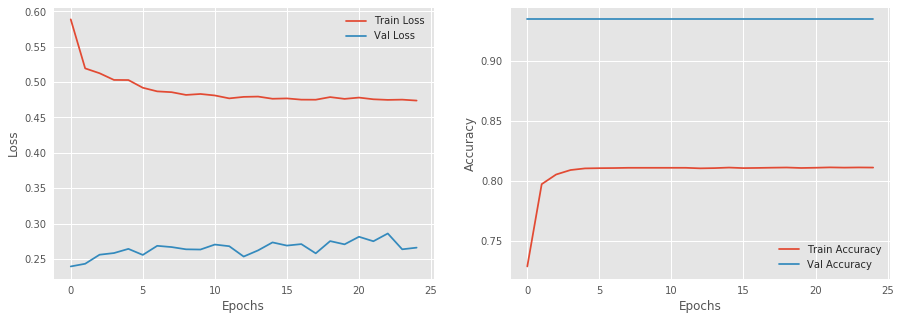

In [19]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [20]:
loss, acc = dense_model2.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

552/552 [==============================] - 0s 47us/step
Accuracy : 0.846


In [21]:
loss, acc = dense_model2.evaluate(X, Y_one_hot)
print('Accuracy : %.3f'%acc)

2756/2756 [==============================] - 0s 45us/step
Accuracy : 0.828


In [22]:
probs = dense_model2.predict_proba(X)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_col_order[i])
    pred_labels.append(l)
    
df2 = copy.deepcopy(data)
df2['Preds'] = pred_labels
for i, col in enumerate(target_col_order):
    df2[col + '_probs'] = probs[:,i]

## Printing/Plotting Classification Metrics

In [23]:
predictions = dense_model2.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('DenseNetv2', actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[433  58]
  [ 43  18]]

 [[267 220]
  [ 17  48]]

 [[  7 475]
  [  1  69]]

 [[  0 457]
  [  0  95]]

 [[  0 449]
  [  0 103]]

 [[  0 418]
  [  0 134]]

 [[  0 438]
  [  0 114]]

 [[  0 464]
  [  0  88]]

 [[  0 484]
  [  0  68]]

 [[223 277]
  [  6  46]]]


Layer : Dense : Weights : (15, 512)
Layer : Dense : Bias : (512,)
Layer : Dense : Weights : (512, 256)
Layer : Dense : Bias : (256,)
Layer : Dense : Weights : (256, 128)
Layer : Dense : Bias : (128,)
Layer : Dense : Weights : (128, 64)
Layer : Dense : Bias : (64,)
Layer : Dense : Weights : (64, 32)
Layer : Dense : Bias : (32,)
Layer : Dense : Weights : (32, 10)
Layer : Dense : Bias : (10,)


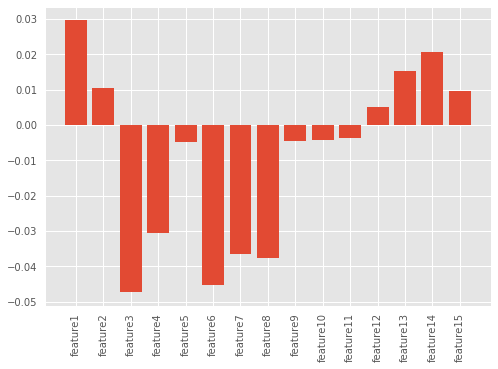

In [24]:
print_weights_per_layer(dense_model2)

dense_weights = dense_model2.get_weights()
important_weights = dense_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v1

Below we are preparing data for LSTM. We are taking look back size of 50 so that we'll look at 50 previous sample to predict current one. We are organizing our dataset in that format so that it can be fed into LSTM.

In [25]:
def prepare_dataset(features,labels, look_back=1):
    X, Y = [], []
    for i in range(len(features)-look_back):
        a = features[i:(i+look_back), :]
        X.append(a)
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

X = data[['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10', 'feature11', 'feature12', 'feature13', 'feature14', 'feature15']].values
Y_one_hot = data[target_col_order].values

ret_vals = data['ret_final'].values

actual_rets_test = ret_vals[X_train.shape[0]:]

print('Actual Return Sizes : ', actual_rets_test.shape)

# split into input and outputs
look_back = 50

X_train, X_test, Y_train_one_hot, Y_test_one_hot = train_test_split(X, Y_one_hot, train_size=0.8, test_size=0.2, shuffle=False)

X_train, Y_train_one_hot = prepare_dataset(X_train, Y_train_one_hot, look_back)
X_test, Y_test_one_hot = prepare_dataset(X_test, Y_test_one_hot, look_back)

X_new, Y_new = prepare_dataset(X, Y_one_hot, look_back)
print('Modified Data Size : ', X_new.shape, Y_new.shape)
print('Train/Test Sizes Modified', X_train.shape, Y_train_one_hot.shape, X_test.shape, Y_test_one_hot.shape)

Actual Return Sizes :  (552,)
Modified Data Size :  (2706, 50, 15) (2706, 10)
Train/Test Sizes Modified (2154, 50, 15) (2154, 10) (502, 50, 15) (502, 10)


Below we have defined LSTM network of only 50 units. This parameter can be tweaked to check whether it improves performance further in future. My guess is that if we increase its value further then it'll performance. Output layer is again sigmoid.

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                13200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                510       
Total params: 13,710
Trainable params: 13,710
Non-trainable params: 0
_________________________________________________________________
None


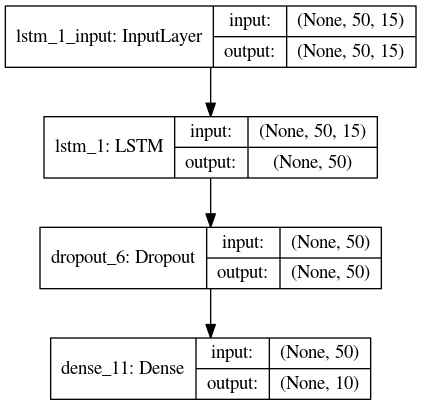

In [26]:
lstm_classif = Sequential([
                        LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
                        Dropout(0.2),
                        Dense(Y_train_one_hot.shape[1], activation='sigmoid')                        
                        ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif1.png', show_shapes=True)
Image.open('lstm_classif1.png')

## Compiling Model

In [27]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [28]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=8, validation_split=0.1, verbose=1, shuffle=False)

Train on 1938 samples, validate on 216 samples
Epoch 1/30
1938/1938 [==============================] - 7s 4ms/step - loss: 0.5016 - accuracy: 0.7879 - val_loss: 0.2651 - val_accuracy: 0.9370
Epoch 2/30
1938/1938 [==============================] - 7s 3ms/step - loss: 0.4738 - accuracy: 0.8174 - val_loss: 0.2622 - val_accuracy: 0.9370
Epoch 3/30
1938/1938 [==============================] - 7s 4ms/step - loss: 0.4720 - accuracy: 0.8181 - val_loss: 0.2570 - val_accuracy: 0.9370
Epoch 4/30
1938/1938 [==============================] - 7s 4ms/step - loss: 0.4713 - accuracy: 0.8180 - val_loss: 0.2635 - val_accuracy: 0.9370
Epoch 5/30
1938/1938 [==============================] - 7s 4ms/step - loss: 0.4704 - accuracy: 0.8179 - val_loss: 0.2632 - val_accuracy: 0.9370
Epoch 6/30
1938/1938 [==============================] - 7s 3ms/step - loss: 0.4679 - accuracy: 0.8181 - val_loss: 0.2653 - val_accuracy: 0.9370
Epoch 7/30
1938/1938 [==============================] - 7s 3ms/step - loss: 0.4678 - accu

## Visualizing Training Stage Results

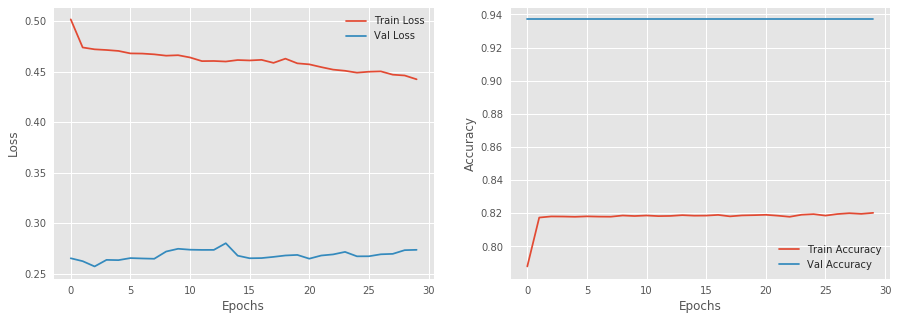

In [29]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [30]:
loss, acc = lstm_classif.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

502/502 [==============================] - 0s 240us/step
Accuracy : 0.842


In [31]:
loss, acc = lstm_classif.evaluate(X_new, Y_new)
print('Accuracy : %.3f'%acc)

2706/2706 [==============================] - 1s 232us/step
Accuracy : 0.835


In [32]:
probs = lstm_classif.predict_proba(X_new)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_col_order[i])
    pred_labels.append(l)
    
df3 = copy.deepcopy(data)
df3['Preds'] = np.hstack((['label_down_200']*50, pred_labels))
for i, col in enumerate(target_col_order):
    df3[col + '_probs'] = np.hstack((np.zeros(50), probs[:,i]))

## Printing/Plotting Classification Metrics

In [33]:
predictions = lstm_classif.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('LSTMv1', actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[213 230]
  [ 18  41]]

 [[ 48 392]
  [ 10  52]]

 [[ 12 425]
  [  4  61]]

 [[  3 412]
  [  0  87]]

 [[  0 406]
  [  0  96]]

 [[  2 377]
  [  1 122]]

 [[ 61 334]
  [ 14  93]]

 [[152 266]
  [ 21  63]]

 [[278 161]
  [ 29  34]]

 [[318 135]
  [ 25  24]]]


## Visualising Weights

Layer : LSTM : Weights : (15, 200)
Layer : Dense : Weights : (50, 200)
Layer : Dense : Bias : (200,)


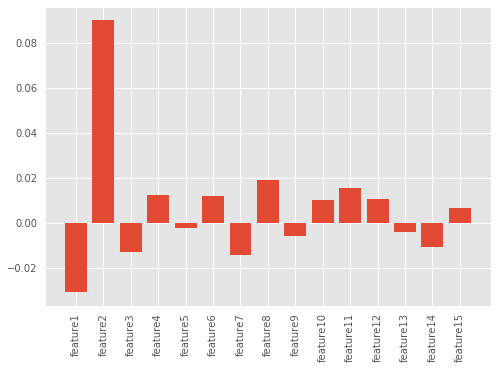

In [34]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

# Time Series Approach With LSTM (Classification) v2
Below we have defined another LSTM model which has 3 LSTM layers of all same unit sizes of 30. Last layer is again sigmoid layer.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50, 30)            5520      
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_12 (Dense)             (None, 10)                310       
Total params: 20,470
Trainable params: 20,470
Non-trainable params: 0
_________________________________________________________________
None


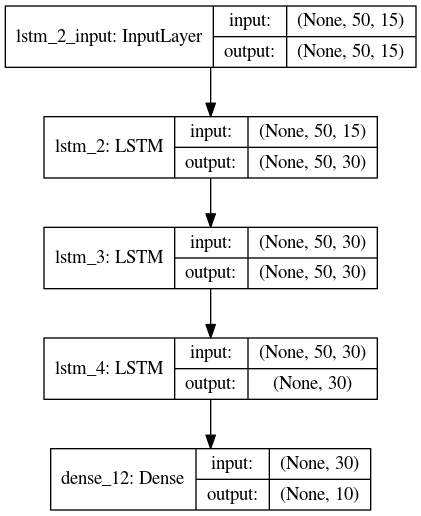

In [35]:
lstm_classif = Sequential([
                LSTM(units=30, return_sequences= True, input_shape=(X_train.shape[1],X_train.shape[2])),
                LSTM(units=30, return_sequences=True),
                LSTM(units=30),
                Dense(Y_train_one_hot.shape[1], activation='sigmoid')
                ])

print(lstm_classif.summary())
plot_model(lstm_classif, to_file='lstm_classif2.png', show_shapes=True)
Image.open('lstm_classif2.png')

## Compiling Model

In [36]:
lstm_classif.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Fitting Model

In [37]:
history = lstm_classif.fit(X_train, Y_train_one_hot, epochs=30, batch_size=8, validation_split=0.1, verbose=1, shuffle=False)

Train on 1938 samples, validate on 216 samples
Epoch 1/30
1938/1938 [==============================] - 20s 10ms/step - loss: 0.4780 - accuracy: 0.8131 - val_loss: 0.2739 - val_accuracy: 0.9370
Epoch 2/30
1938/1938 [==============================] - 18s 10ms/step - loss: 0.4669 - accuracy: 0.8182 - val_loss: 0.2678 - val_accuracy: 0.9370
Epoch 3/30
1938/1938 [==============================] - 18s 10ms/step - loss: 0.4657 - accuracy: 0.8182 - val_loss: 0.2649 - val_accuracy: 0.9370
Epoch 4/30
1938/1938 [==============================] - 18s 9ms/step - loss: 0.4649 - accuracy: 0.8182 - val_loss: 0.2646 - val_accuracy: 0.9370
Epoch 5/30
1938/1938 [==============================] - 18s 10ms/step - loss: 0.4645 - accuracy: 0.8182 - val_loss: 0.2701 - val_accuracy: 0.9370
Epoch 6/30
1938/1938 [==============================] - 18s 10ms/step - loss: 0.4644 - accuracy: 0.8155 - val_loss: 0.2636 - val_accuracy: 0.9370
Epoch 7/30
1938/1938 [==============================] - 19s 10ms/step - loss: 

## Visualizing Training Stage Results

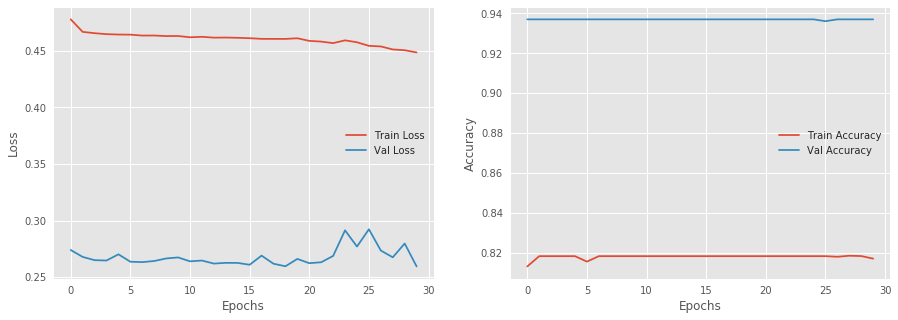

In [38]:
plot_loss_and_accuracy(history)

## Performance Evaluation on Test Data

In [39]:
loss, acc = lstm_classif.evaluate(X_test, Y_test_one_hot)
print('Accuracy : %.3f'%acc)

502/502 [==============================] - 0s 550us/step
Accuracy : 0.842


In [40]:
loss, acc = lstm_classif.evaluate(X_new, Y_new)
print('Accuracy : %.3f'%acc)

2706/2706 [==============================] - 1s 553us/step
Accuracy : 0.833


In [41]:
probs = lstm_classif.predict_proba(X_new)
pred_labels = []
for row in probs:
    l = []
    for i, val in enumerate(row):
        if val > 0.1:
            l.append(target_col_order[i])
    pred_labels.append(l)
    
df4 = copy.deepcopy(data)
df4['Preds'] = np.hstack((['label_down_200']*50, pred_labels))
for i, col in enumerate(target_col_order):
    df4[col + '_probs'] = np.hstack((np.zeros(50), probs[:,i]))

## Printing/Plotting Classification Metrics

In [42]:
predictions = lstm_classif.predict_proba(X_test)
predictions = (predictions > 0.1).astype(np.int32)

print_plot_metrics('LSTMv2' , actual_rets_test, Y_test_one_hot, predictions)

Confusion Matrix : 
 [[[377  66]
  [ 30  29]]

 [[229 211]
  [ 22  40]]

 [[  0 437]
  [  0  65]]

 [[  0 415]
  [  0  87]]

 [[  0 406]
  [  0  96]]

 [[  0 379]
  [  0 123]]

 [[  0 395]
  [  0 107]]

 [[ 84 334]
  [ 11  73]]

 [[358  81]
  [ 45  18]]

 [[395  58]
  [ 39  10]]]


## Visualising Weights

Layer : LSTM : Weights : (15, 120)
Layer : LSTM : Weights : (30, 120)
Layer : LSTM : Weights : (120,)
Layer : Dense : Weights : (30, 120)
Layer : Dense : Bias : (30, 120)


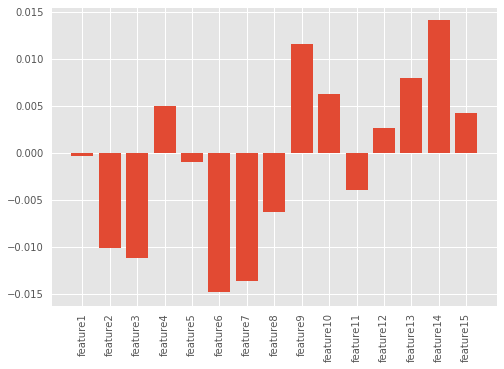

In [43]:
print_weights_per_layer(lstm_classif)

lstm_weights = lstm_classif.get_weights()
important_weights = lstm_weights[0].mean(axis=1)

with plt.style.context(('seaborn','ggplot')):
    plt.bar(x=['feature'+str(i) for i in range(1,16)], height=important_weights, width=0.8)
    plt.xticks(rotation='vertical')

In [44]:
with pd.ExcelWriter('Final_Output.xlsx') as writer:
    for sheet_name, df in [('DenseNetv1',df1), ('DenseNetv2',df2), ('LSTMv1', df3), ('LSTMv2', df4)]:
        df1.to_excel(writer, sheet_name= sheet_name)

In [45]:
from IPython.display import FileLink
FileLink('Final_Output.xlsx')

/kaggle/working/Final_Output.xlsx